In [1]:
import os
import numpy as np
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
import os
from PIL import Image, ImageOps
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle

def load_and_normalize_images(base_folder_path, class_labels, image_size=(64, 64)):
    all_sequences = []
    all_labels = []

    for class_folder, label in class_labels.items():
        class_path = os.path.join(base_folder_path, class_folder)

        sequence_folders = [f for f in os.listdir(class_path) if os.path.isdir(os.path.join(class_path, f))]

        for sequence_folder in sequence_folders:
            sequence_path = os.path.join(class_path, sequence_folder)

            file_names = os.listdir(sequence_path)
            sorted_files = sorted(file_names, key=lambda x: int(os.path.splitext(x)[0]))

            images = []

            for file_name in sorted_files:
                file_path = os.path.join(sequence_path, file_name)
                image = Image.open(file_path)
                image = ImageOps.grayscale(image)
                image = image.resize(image_size) 
                image_array = np.array(image) / 255.0  # Normalizar
                images.append(image_array)
            images = np.array(images) 
            all_sequences.append(images)
            all_labels.append(label)

    all_sequences = np.array(all_sequences)  
    all_labels = np.array(all_labels)  
    
    return all_sequences, all_labels

def display_sequences(sequences, num_sequences_to_show=5):
    for sequence in sequences[:num_sequences_to_show]:
        fig, axes = plt.subplots(1, len(sequence), figsize=(20, 20))
        for i, image in enumerate(sequence):
            if len(sequence) == 1:
                ax = axes
            else:
                ax = axes[i]
            ax.imshow(image)
            ax.axis('off')
        plt.show()

# Configuración inicial
class_labels = {
    "neutral": 0,
    "frustration": 1
    #
}



(712, 30, 64, 64)
(712,)


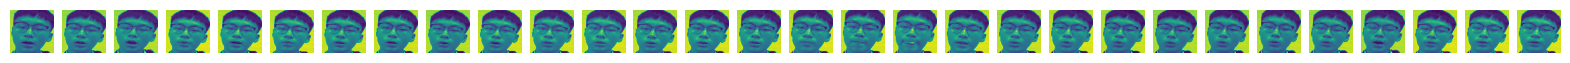

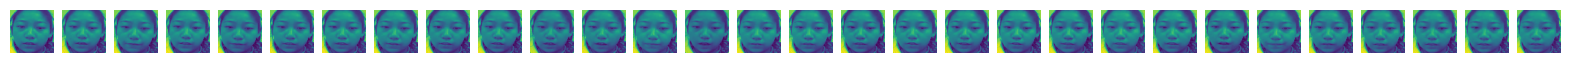

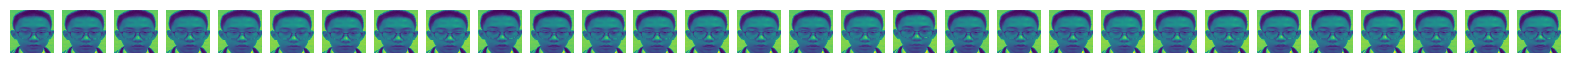

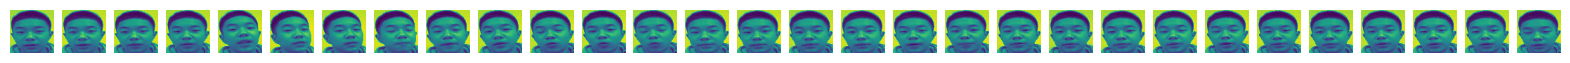

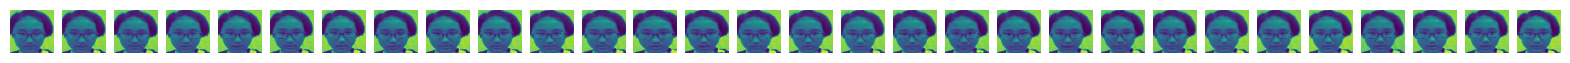

In [3]:
X_train, y_train = load_and_normalize_images('low_data/train'  , class_labels)
print(X_train.shape)
print(y_train.shape)
X_train, y_train = shuffle(X_train, y_train, random_state=42)
# Mostrar solo las primeras 5 secuencias
display_sequences(X_train, num_sequences_to_show=5)


(133, 30, 64, 64)
(133,)


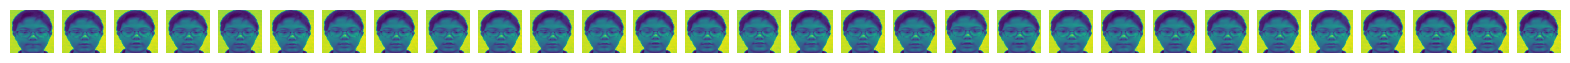

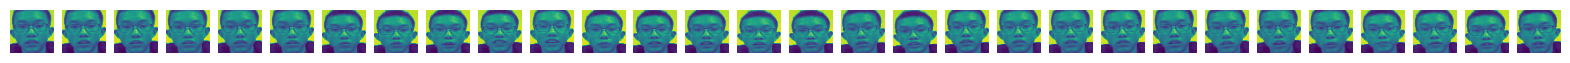

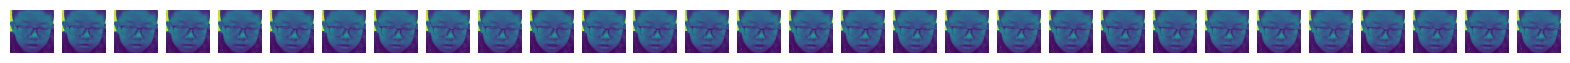

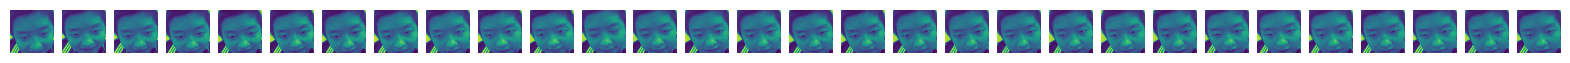

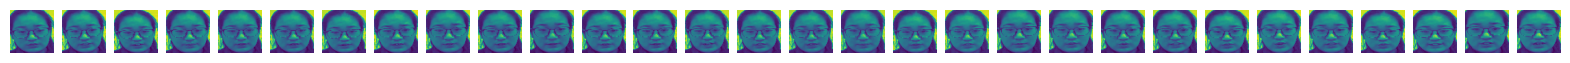

In [4]:
X_test, y_test = load_and_normalize_images('low_data/test' , class_labels)
X_test, y_test = shuffle(X_test, y_test, random_state=42)
print(X_test.shape)
print(y_test.shape)

display_sequences(X_test, num_sequences_to_show=5)

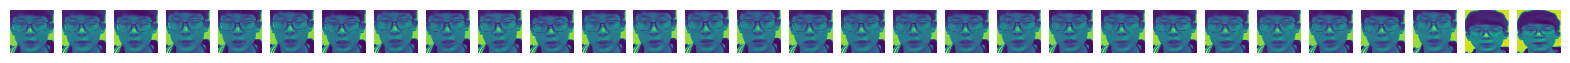

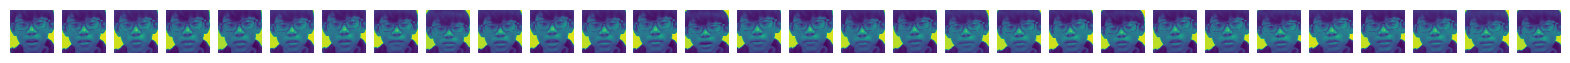

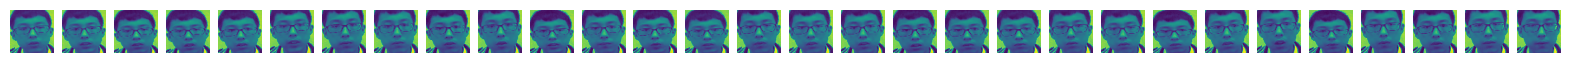

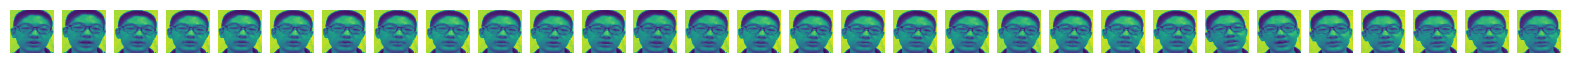

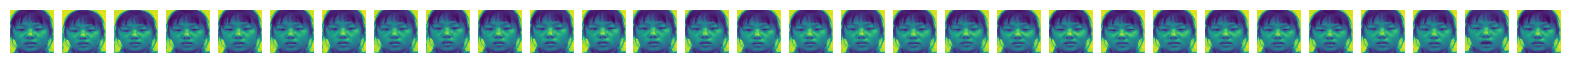

(132, 30, 64, 64)
(132,)


In [5]:
X_val, y_val = load_and_normalize_images('low_data/dev', class_labels)
X_val, y_val = shuffle(X_val, y_val, random_state=42)

display_sequences(X_val, num_sequences_to_show=5)
print(X_val.shape)
print(y_val.shape)

In [6]:
X_val

array([[[[0.1254902 , 0.11372549, 0.10196078, ..., 0.17254902,
          0.2       , 0.6       ],
         [0.11764706, 0.10588235, 0.10196078, ..., 0.1372549 ,
          0.22745098, 0.45882353],
         [0.11764706, 0.10980392, 0.10588235, ..., 0.14509804,
          0.2       , 0.48235294],
         ...,
         [0.17254902, 0.58823529, 0.82745098, ..., 0.0627451 ,
          0.0627451 , 0.05882353],
         [0.17254902, 0.81960784, 0.86666667, ..., 0.07058824,
          0.05882353, 0.05490196],
         [0.54901961, 0.81568627, 0.85882353, ..., 0.0627451 ,
          0.06666667, 0.05098039]],

        [[0.12156863, 0.11764706, 0.11372549, ..., 0.14117647,
          0.2       , 0.6       ],
         [0.12156863, 0.11372549, 0.11372549, ..., 0.15686275,
          0.20392157, 0.52941176],
         [0.12156863, 0.11372549, 0.10980392, ..., 0.15294118,
          0.17647059, 0.5254902 ],
         ...,
         [0.25882353, 0.44313725, 0.81960784, ..., 0.05882353,
          0.03921569, 0.0

In [7]:
from keras.utils import to_categorical
y_train_categorical = to_categorical(y_train)
y_test_categorical = to_categorical(y_test)
y_val_categorical = to_categorical(y_val)
height = 64
width = 64
channels = 3
sequence_length = 30

In [8]:
y_train_categorical

array([[0., 1.],
       [0., 1.],
       [1., 0.],
       ...,
       [1., 0.],
       [0., 1.],
       [1., 0.]], dtype=float32)

In [17]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, TimeDistributed,Dropout,BatchNormalization

cnn = Sequential()
cnn.add(Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 1)))
cnn.add(MaxPooling2D(pool_size=(2, 2)))

cnn.add(Conv2D(64, (3, 3), activation='relu'))
cnn.add(MaxPooling2D(pool_size=(2, 2)))

cnn.add(Conv2D(128, (3, 3), activation='relu'))
cnn.add(BatchNormalization())
cnn.add(MaxPooling2D(pool_size=(2, 2)))
cnn.add(Dropout(0.2)) 

cnn.add(Flatten())

In [13]:
import tensorflow as tf
tf.config.run_functions_eagerly(True)

In [18]:
from keras.models import Model
from keras.layers import Input, LSTM, Dense
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

sequence_input = Input(shape=(30, 64, 64, 1))  # Secuencia de imágenes
cnn_out = TimeDistributed(cnn)(sequence_input)

lstm_out = LSTM(100)(cnn_out)
dense_out = Dense(64,activation='relu')(lstm_out)
predictions = Dense(1, activation='sigmoid')(dense_out)

model = Model(inputs=sequence_input, outputs=predictions)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])



In [19]:
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/20
23/23 [==============================] - 88s 4s/step - loss: 0.6950 - accuracy: 0.5815 - val_loss: 0.7222 - val_accuracy: 0.1212
Epoch 2/20
23/23 [==============================] - 83s 4s/step - loss: 0.5645 - accuracy: 0.7121 - val_loss: 0.8129 - val_accuracy: 0.1288
Epoch 3/20
23/23 [==============================] - 84s 4s/step - loss: 0.4278 - accuracy: 0.8244 - val_loss: 1.1708 - val_accuracy: 0.1061
Epoch 4/20
23/23 [==============================] - 84s 4s/step - loss: 0.2941 - accuracy: 0.9017 - val_loss: 1.2298 - val_accuracy: 0.1136
Epoch 5/20
23/23 [==============================] - 83s 4s/step - loss: 0.2169 - accuracy: 0.9298 - val_loss: 0.4581 - val_accuracy: 0.7652
Epoch 6/20
23/23 [==============================] - 83s 4s/step - loss: 0.1423 - accuracy: 0.9621 - val_loss: 0.3720 - val_accuracy: 0.8712
Epoch 7/20
23/23 [==============================] - 82s 4s/step - loss: 0.0923 - accuracy: 0.9775 - val_loss: 0.4438 - val_accuracy: 0.9091
Epoch 8/20
23/23 [==

In [20]:
val_loss, val_accuracy = model.evaluate(X_val, y_val_categorical)
print(f'Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}')

ValueError: `logits` and `labels` must have the same shape, received ((32, 1) vs (32, 2)).

In [ ]:
loss, accuracy = model.evaluate(X_test, y_test_categorical)
print(f'Accuracy: {accuracy*100:.2f}%')

5/5 [==============================] - 2s 426ms/step - loss: 0.5682 - accuracy: 0.9248
Accuracy: 92.48%


In [ ]:
predictions = model.predict(X_test)
predictions

5/5 [==============================] - 3s 434ms/step


array([[9.99986529e-01, 1.34681322e-05],
       [9.99935269e-01, 6.47429260e-05],
       [9.99972224e-01, 2.77788986e-05],
       [8.83395672e-01, 1.16604306e-01],
       [9.99890924e-01, 1.09057357e-04],
       [9.99979377e-01, 2.06012883e-05],
       [1.03186239e-02, 9.89681423e-01],
       [9.99925256e-01, 7.47222803e-05],
       [9.99980330e-01, 1.97262270e-05],
       [9.99901056e-01, 9.88787215e-05],
       [9.99989867e-01, 1.01241194e-05],
       [9.99213815e-01, 7.86175195e-04],
       [9.99999642e-01, 3.57783307e-07],
       [9.99915600e-01, 8.44349197e-05],
       [9.99959946e-01, 4.01054349e-05],
       [9.99464214e-01, 5.35820902e-04],
       [8.60909045e-01, 1.39090955e-01],
       [9.99969840e-01, 3.02097633e-05],
       [9.99991655e-01, 8.32066416e-06],
       [9.99991298e-01, 8.68924599e-06],
       [6.71844900e-01, 3.28155100e-01],
       [9.99995828e-01, 4.13178395e-06],
       [9.99996066e-01, 3.93279061e-06],
       [9.99318004e-01, 6.82051352e-04],
       [9.989262

In [ ]:
predicted_labels = np.argmax(predictions, axis=1)

In [ ]:
predicted_labels

array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0], dtype=int64)

In [ ]:
y_test

array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       0])

In [ ]:
for i in range(132):
    print(f"Muestra {i+1}:")
    print("Predicción:", predicted_labels[i], "(", predictions[i][predicted_labels[i]], ")")
    print("Etiqueta real:", y_val[i])
    print()

Muestra 1:
Predicción: 0 ( 0.9999865 )
Etiqueta real: 0

Muestra 2:
Predicción: 0 ( 0.99993527 )
Etiqueta real: 0

Muestra 3:
Predicción: 0 ( 0.9999722 )
Etiqueta real: 0

Muestra 4:
Predicción: 0 ( 0.8833957 )
Etiqueta real: 0

Muestra 5:
Predicción: 0 ( 0.9998909 )
Etiqueta real: 0

Muestra 6:
Predicción: 0 ( 0.9999794 )
Etiqueta real: 0

Muestra 7:
Predicción: 1 ( 0.9896814 )
Etiqueta real: 0

Muestra 8:
Predicción: 0 ( 0.99992526 )
Etiqueta real: 1

Muestra 9:
Predicción: 0 ( 0.99998033 )
Etiqueta real: 0

Muestra 10:
Predicción: 0 ( 0.99990106 )
Etiqueta real: 0

Muestra 11:
Predicción: 0 ( 0.99998987 )
Etiqueta real: 0

Muestra 12:
Predicción: 0 ( 0.9992138 )
Etiqueta real: 0

Muestra 13:
Predicción: 0 ( 0.99999964 )
Etiqueta real: 0

Muestra 14:
Predicción: 0 ( 0.9999156 )
Etiqueta real: 0

Muestra 15:
Predicción: 0 ( 0.99995995 )
Etiqueta real: 0

Muestra 16:
Predicción: 0 ( 0.9994642 )
Etiqueta real: 0

Muestra 17:
Predicción: 0 ( 0.86090904 )
Etiqueta real: 0

Muestra 18:
Pre

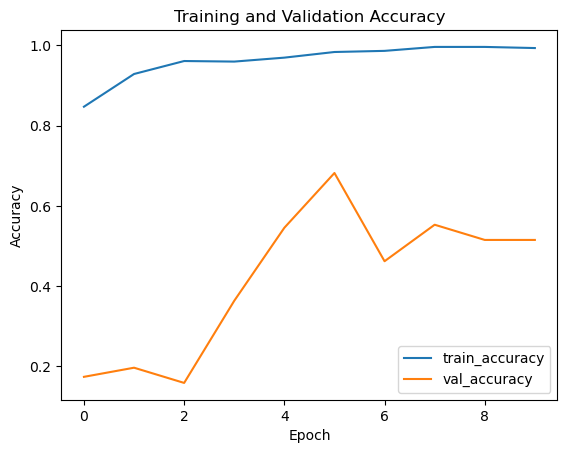

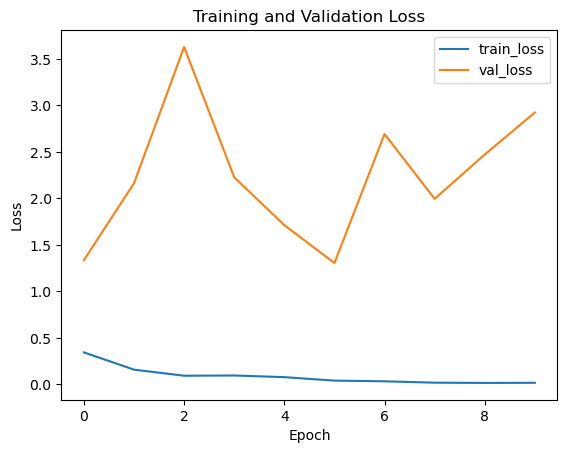

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.show()

plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

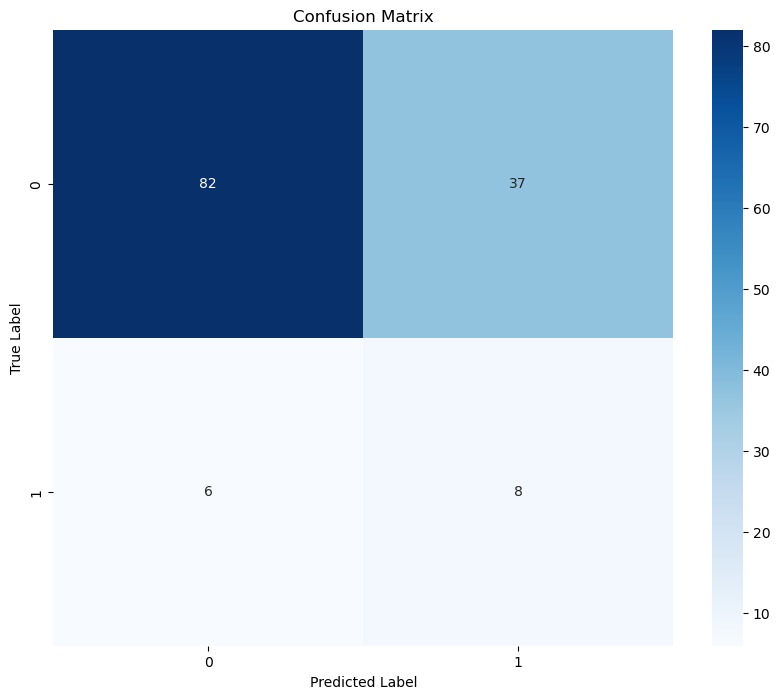

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

conf_matrix = confusion_matrix(y_test, predicted_labels)


plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()